In [4]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time 
from importlib import reload
import copy
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Circle, Rectangle

import poppy

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from adefc_vortex import dm
from adefc_vortex import props
from adefc_vortex import efc_1dm as efc
import adefc_vortex.pwp as pwp
import adefc_vortex.scoob_model as scoobm
import adefc_vortex.scoob_interface as scoobi

import purepyindi
from purepyindi import INDIClient
import purepyindi2
from purepyindi2 import IndiClient
client0 = INDIClient('localhost', 7624)
client0.start()
client = IndiClient()
client.connect()
client.get_properties()

wavelength_c = 633e-9
npix = 1000


In [2]:
scoobi.home_block(client0)

In [8]:
scoobi.move_block_out(client0)

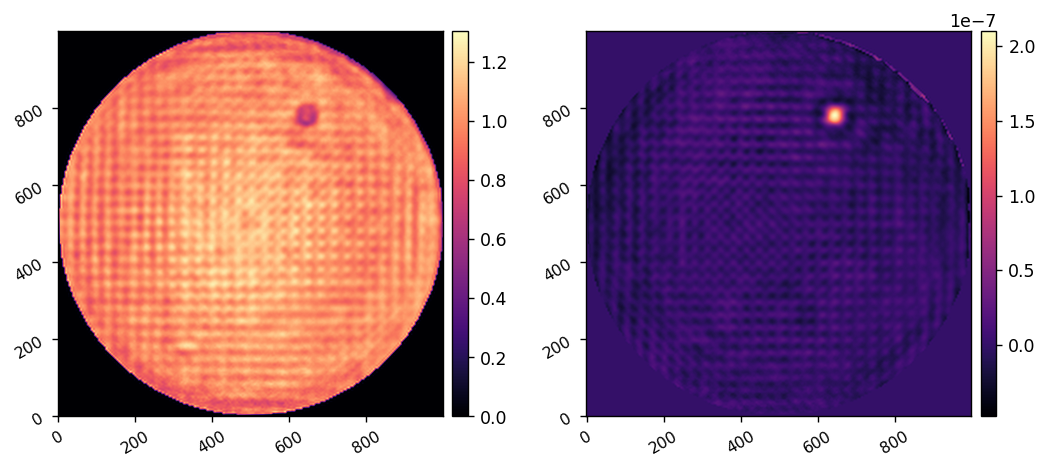

In [5]:
# wfe_amp = xp.array(fits.getdata('data/pr_est_amp.fits'))
# wfe_opd = xp.array(fits.getdata('data/pr_est_opd.fits'))
# imshow2(wfe_amp, wfe_opd)

pr_fit = utils.load_pickle(f'data/fpm_pr_data.pkl')

wfe_amp = pr_fit['processed_amp']
wfe_opd = pr_fit['processed_opd']
imshow2(wfe_amp, wfe_opd)

In [7]:
reload(scoobi)
xc, yc = (4600, 3400)
npsf = 256
scoobi.set_zwo_roi(xc, yc, npsf, client0)

In [3]:
reload(scoobi)
I = scoobi.SCOOBI(scicam_channel='camsci', dm_channel='dm00disp05')
I.npsf = 150

# Do the normalization

In [13]:
scoobi.move_psf(50, 0, client0)

In [14]:
reload(scoobi)
I.set_zwo_exp_time(0.000500, client0)

Set the ZWO exposure time to 5.00e-04s


In [15]:
reload(scoobi)
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [16]:
reload(scoobi)
I.set_fib_atten(35, client)

Set the fiber attenuation to 35.0


INFO:utils:Got semaphore index 1.


50886.76


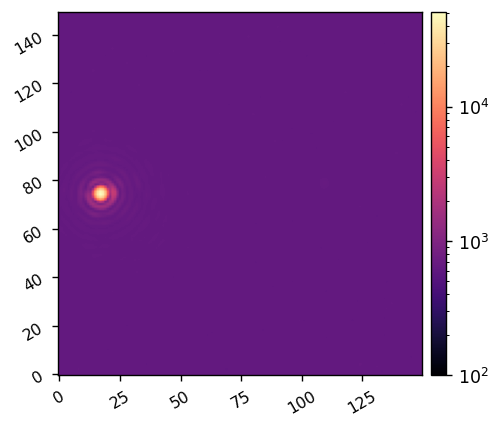

In [17]:
I.NSCICAM = 200
ref_psf = I.snap()
print(xp.max(ref_psf))
imshow1(ref_psf, lognorm=True, vmin=1e2)

In [18]:
# I.ref_psf_params = {
#     'ref_psf':copy.copy(ref_psf),
#     'Imax': copy.copy(xp.max(ref_psf)),
#     'texp': copy.copy(I.texp), 
#     'atten': copy.copy(I.atten),
#     'gain': copy.copy(I.gain),
# }
# utils.save_pickle(f'data/{today}_ref_psf_params.pkl', I.ref_psf_params)

I.ref_psf_params = utils.load_pickle(f'data/{today}_ref_psf_params.pkl')

Saved data to:  data/20241218_ref_psf_params.pkl


In [39]:
scoobi.move_psf(1, 0, client0)


In [43]:
scoobi.move_psf(0, -1, client0)

In [47]:
I.set_fib_atten(20, client)

Set the fiber attenuation to 20.0


In [45]:
I.set_zwo_exp_time(0.1, client0)

Set the ZWO exposure time to 1.00e-01s


In [29]:
I.set_zwo_gain(120, client0)

Set the ZWO gain setting to 120.0


In [48]:
reload(scoobi)
scoobi.move_block_in(client0)

Saved data to:  data/20241218_camsci_dark_frame.pkl


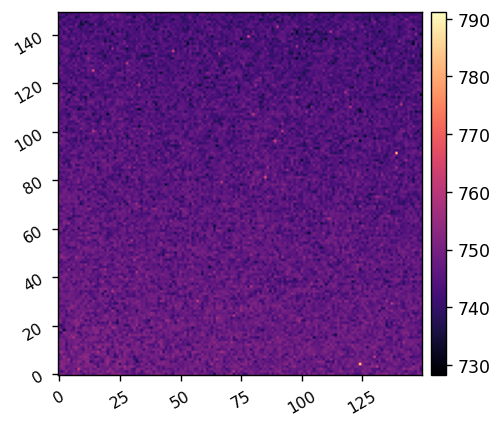

In [49]:
# I.NSCICAM = 200
# I.subtract_dark = False
# I.return_ni = False
# dark_frame = I.snap()
# utils.save_pickle(f'data/{today}_camsci_dark_frame.pkl', dark_frame)
# I.df = copy.copy(dark_frame)
# imshow1(dark_frame)

dark_frame = utils.load_pickle(f'data/{today}_camsci_dark_frame.pkl')
I.df = copy.copy(dark_frame)
imshow1(dark_frame)

In [50]:
reload(scoobi)
scoobi.move_block_out(client0)

In [70]:
I.set_fib_atten(20, client)

Set the fiber attenuation to 25.0


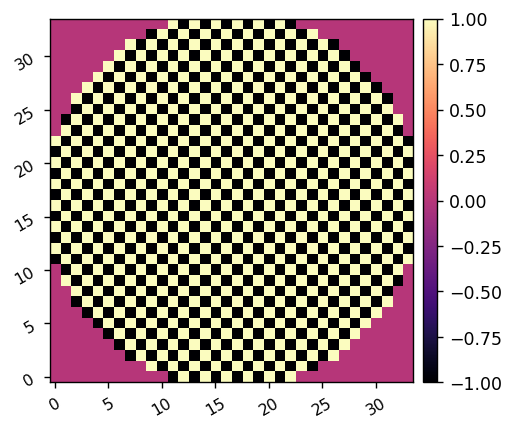

In [7]:
reload(scoobi.utils)
waffle_command = utils.make_fourier_command(x_cpa=17, y_cpa=17) * xp.array(I.dm_mask)
imshow1(waffle_command)

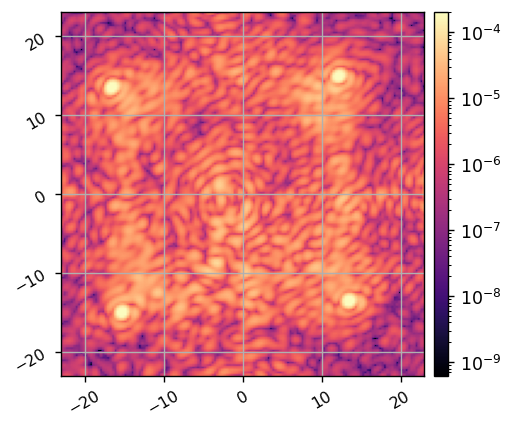

In [58]:
I.set_dm(15e-9 * waffle_command)
I.x_shift = 0
I.y_shift = 0

# original_texp = I.texp
# I.set_zwo_exp_time(0.005, client0)

I.NSCICAM = 10
I.subtract_dark = True
I.return_ni = True
waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=I.psf_pixelscale_lamDc, grid=True)

# I.set_zwo_exp_time(original_texp, client0)


Centroids:
 [[ 24.772381    25.8544294 ]
 [ 20.60775951 118.52998245]
 [114.03893136 123.12191789]
 [118.26753386  30.53662798]
 [ 24.772381    25.8544294 ]]


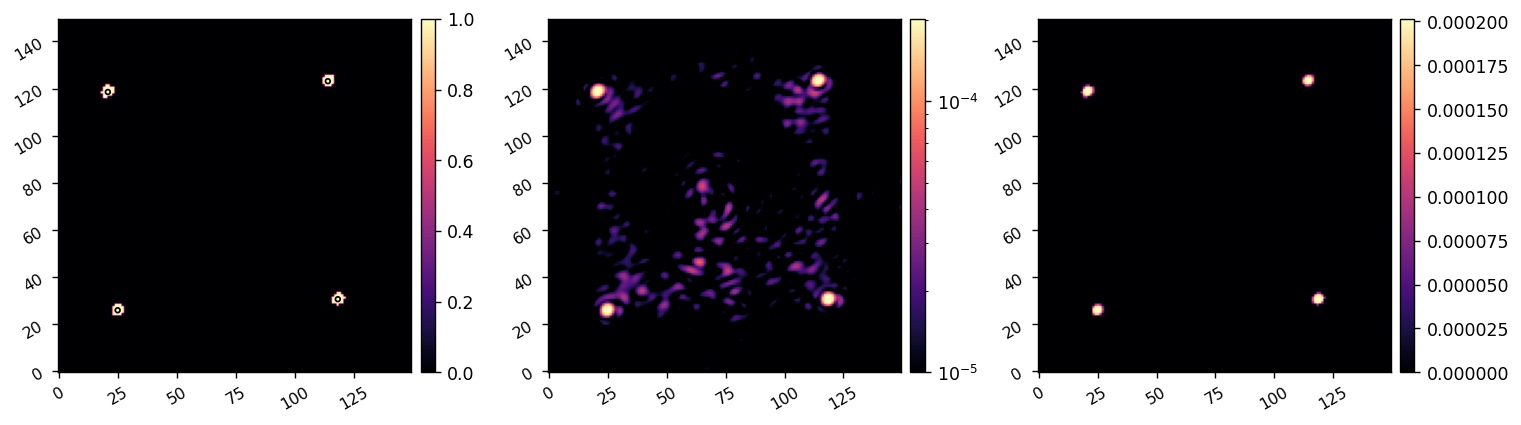

Angle:  87.28282951937896
Measured center in X:  69.44280770001856
Measured center in Y:  74.5286550442502
Required shift in X:  6.0
Required shift in Y:  0.0


In [59]:
reload(utils)

xshift, yshift, angle = utils.measure_center_and_angle(
    waffle_im, 
    I.psf_pixelscale_lamDc, 
    im_thresh=7e-5, 
    r_thresh=16,
)

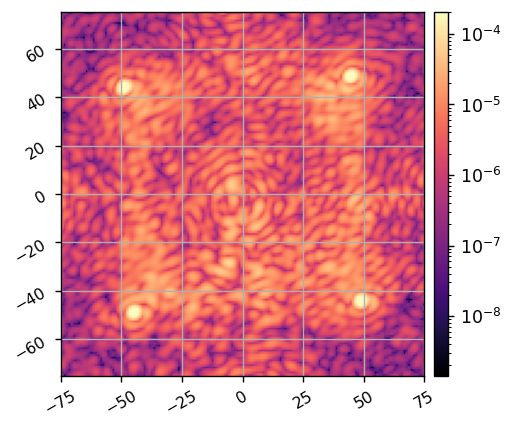

In [60]:
I.NSCICAM = 10
I.npsf = 150
I.x_shift = xshift -1
I.y_shift = yshift

I.subtract_dark = True
I.return_ni = True

waffle_im = I.snap()
imshow1(waffle_im, lognorm=True, pxscl=1, grid=True)

In [11]:
iwa = 3
owa = 10
rotation = 180
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, iwa, owa, edge=iwa, rotation=rotation)


4.0036798574035625e-06


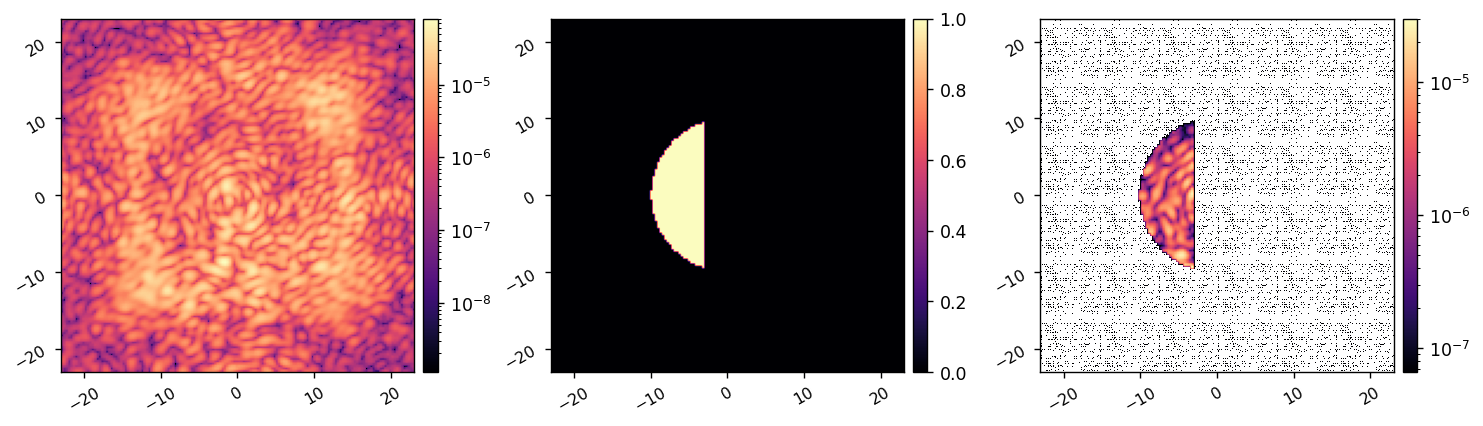

In [61]:
iwa = 3
owa = 10
rotation = 180
control_mask = utils.create_annular_focal_plane_mask(I.npsf, I.psf_pixelscale_lamDc, iwa, owa, edge=iwa, rotation=rotation)

I.zero_dm()
I.NSCICAM = 10
I.subtract_dark = True
I.return_ni = True

ref_coro_im = I.snap()
print(xp.mean(ref_coro_im[control_mask]))
imshow3(ref_coro_im, control_mask, control_mask * ref_coro_im,
        lognorm1=True, lognorm3=True, pxscl=I.psf_pixelscale_lamDc)

# Create the model

In [12]:
reload(scoobm)
M = scoobm.MODEL(
    dm_beam_diam=9.4*u.mm, 
    lyot_pupil_diam=9.4*u.mm,
    # dm_shift=np.array([0.1,0.0])*u.mm,
    # lyot_shift=np.array([0,0.35])*u.mm,
)
M.AMP = wfe_amp
M.OPD = wfe_opd

M.reverse_lyot = 1
M.flip_lyot = 1
M.det_rotation = 177.5

M.setattr('use_vortex', False)
ref_psf = M.snap()
M.setattr('Imax_ref', xp.max(ref_psf))

M.set_dm(7.5e-9 * waffle_command)
M.setattr('use_vortex', True)
m_waffle_im = M.snap()

# imshow2(m_waffle_im, waffle_im-m_waffle_im, lognorm1=True, vmin1=1e-9)
# fpwf = M.forward(np.zeros(M.Nacts), use_vortex=True, plot=True)


# Compute Jacobian with the model

In [13]:
reload(efc)

jac = efc.compute_jacobian(
    M, 
    control_mask, 
    amp=1e-9, 
    current_acts=None, 
    wavelength=I.wavelength_c,
)

(2044, 951)


KeyboardInterrupt: 

In [ ]:
utils.save_jacobian(f'data/{today}_efc_jac.pkl')

In [ ]:
jac = utils.load_jacobian(f'data/{20241218}_efc_jac.pkl')

In [ ]:
cm15 = utils.beta_reg(jac, -1.5)
cm20 = utils.beta_reg(jac, -2.0)
cm25 = utils.beta_reg(jac, -2.5)
cm30 = utils.beta_reg(jac, -3.0)
cm35 = utils.beta_reg(jac, -3.5)
cm40 = utils.beta_reg(jac, -4.0)
cm45 = utils.beta_reg(jac, -4.5)
cm50 = utils.beta_reg(jac, -5.0)

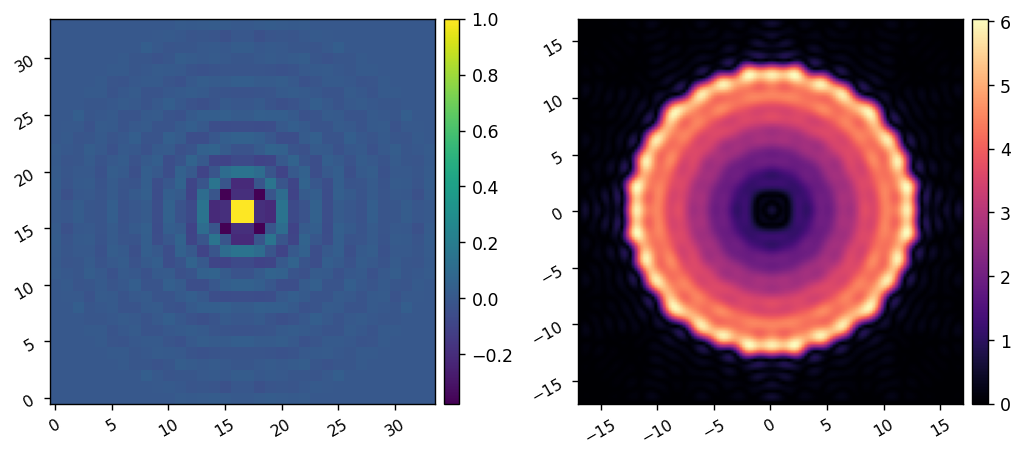

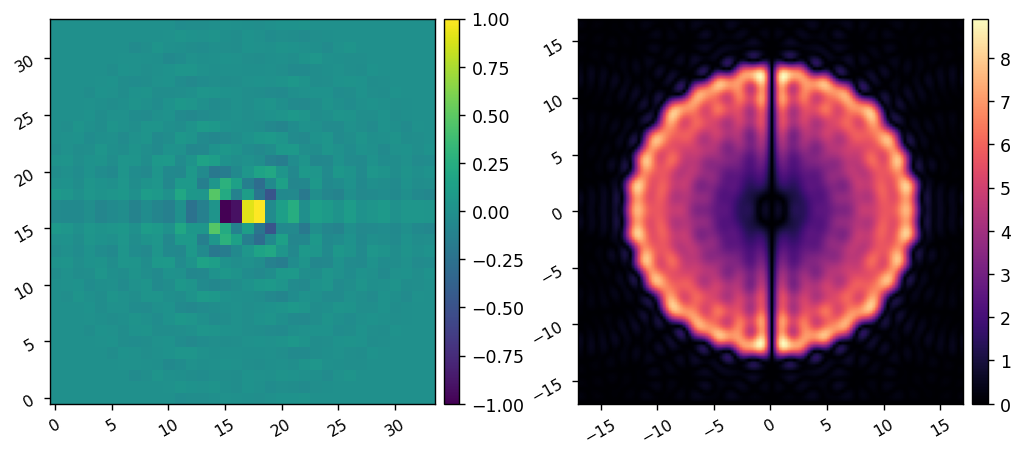

In [70]:
reload(utils)
fourier_probes = utils.create_fourier_probes(
    xp.array(I.dm_mask), 
    I.npsf, 
    I.psf_pixelscale_lamDc, 
    iwa-0.5, owa+2, 
    # edge=iwa-0.5,
    fourier_sampling=0.75, 
    nprobes=2,
    plot=True,
    use_weighting=True
)

In [57]:
I.wavelength_c

6.33e-07

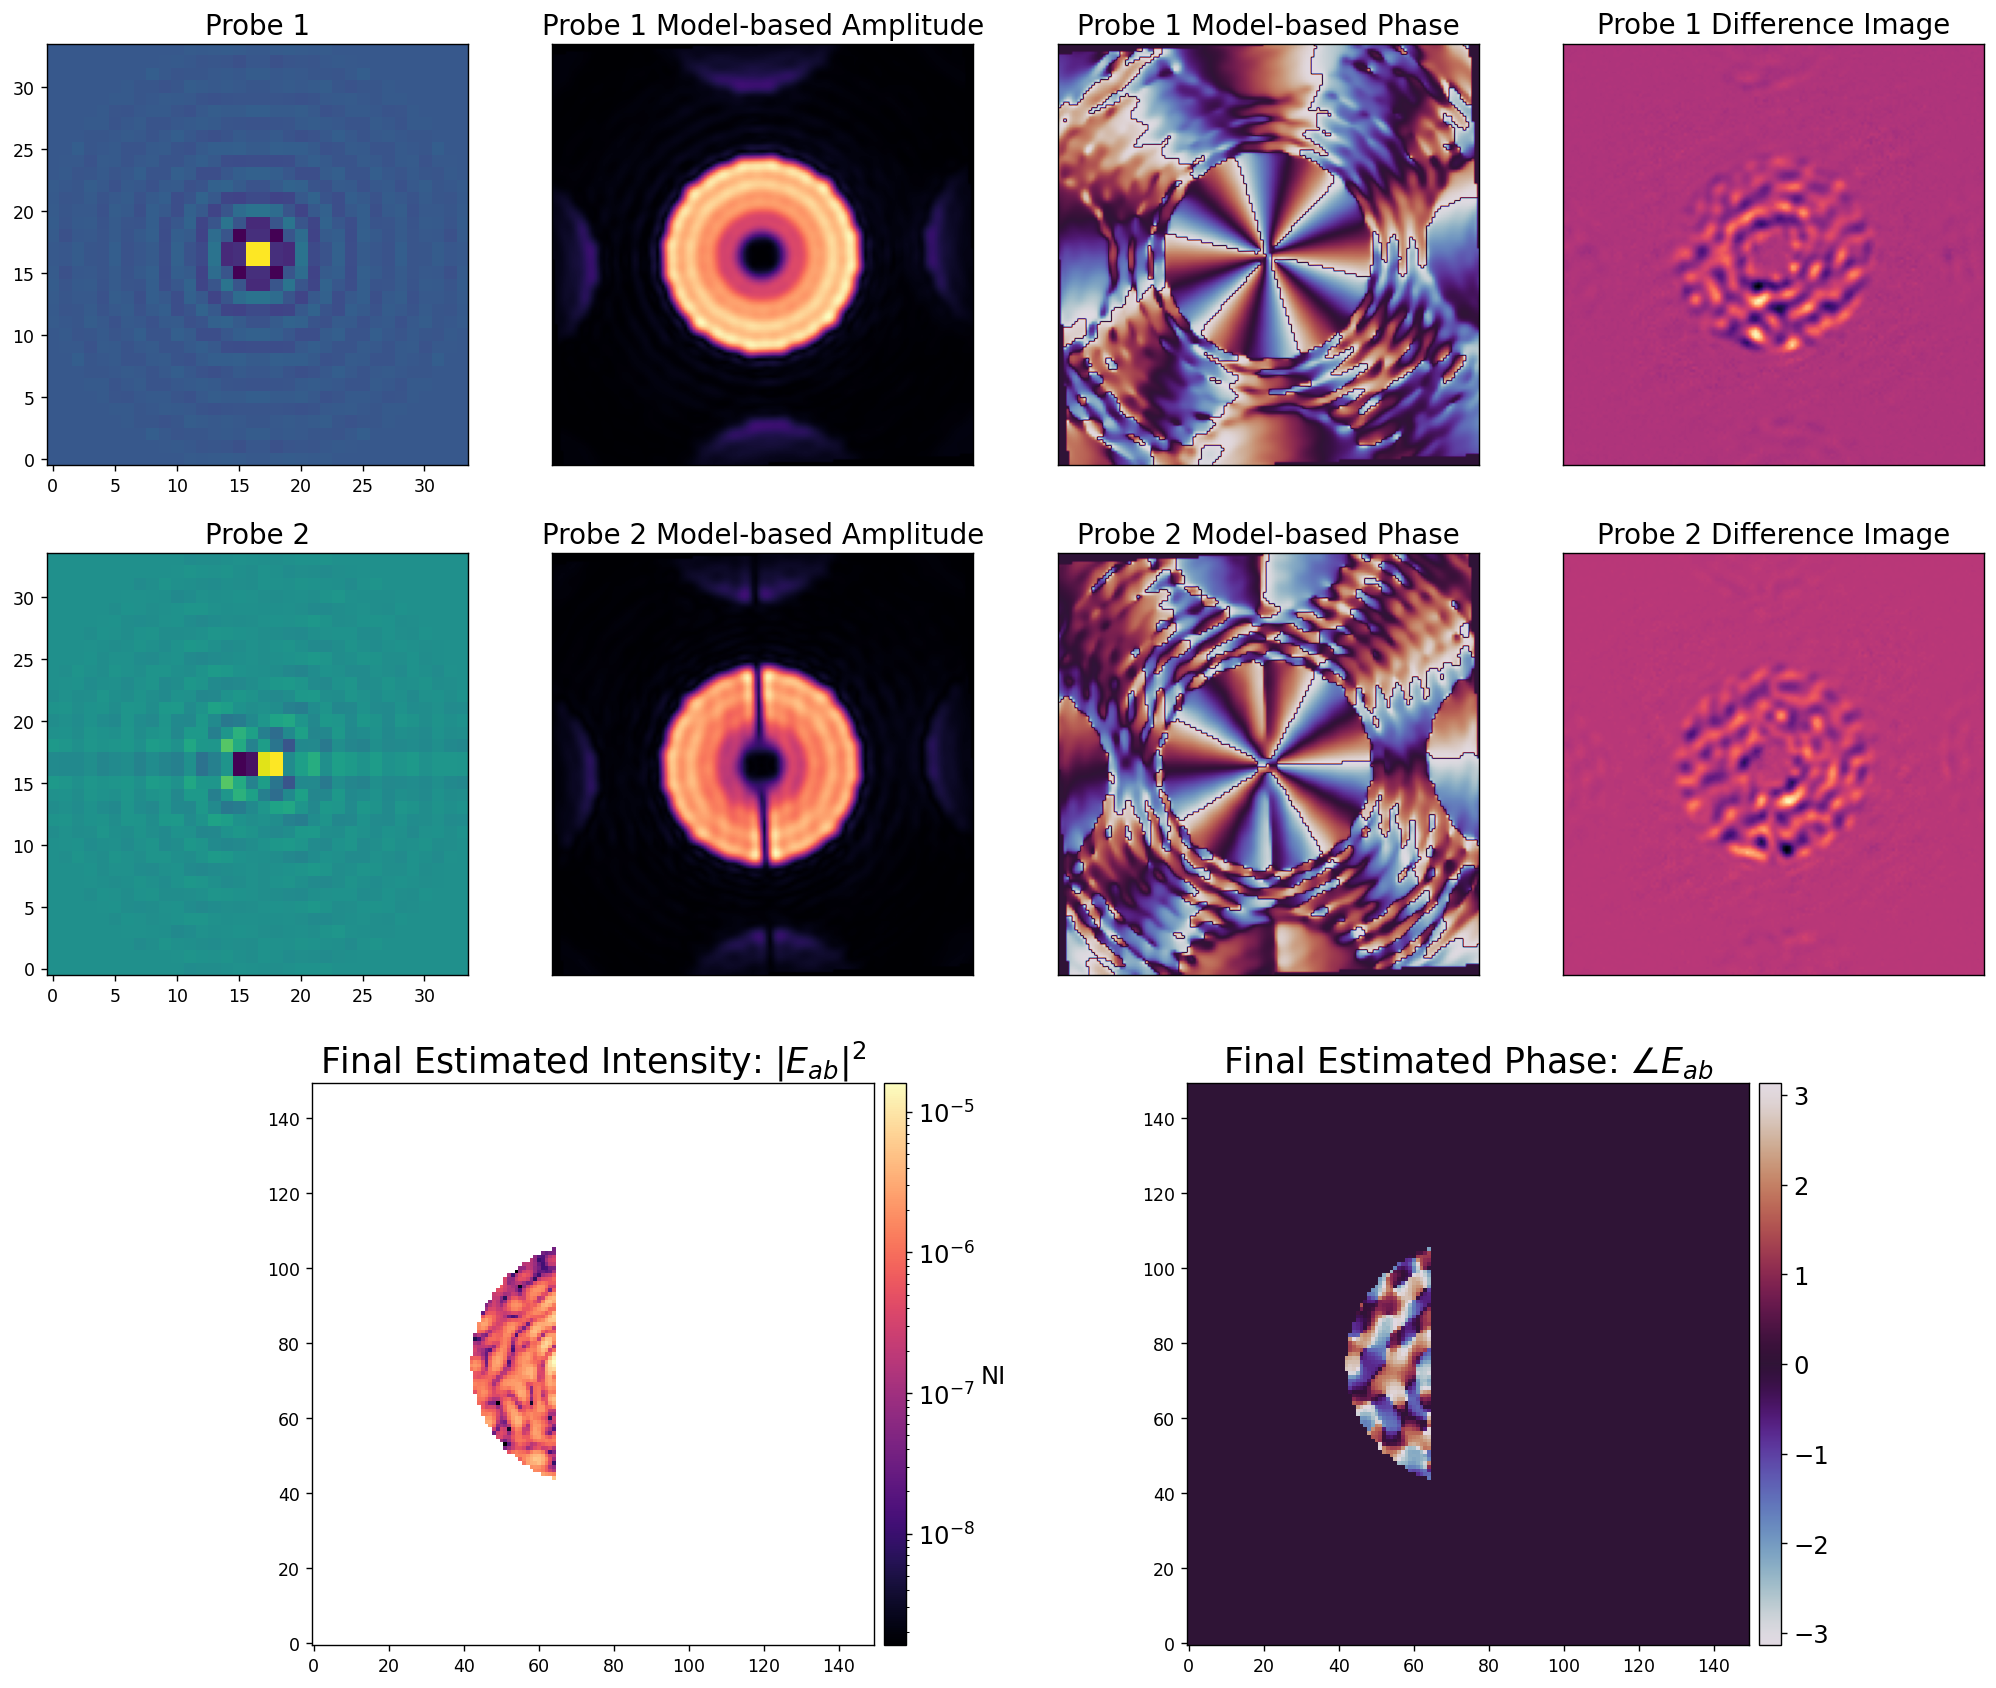

In [71]:
reload(pwp)

acts = xp.zeros(M.Nacts)

I.set_dm(scoobm.acts_to_command(acts, M.dm_mask))
E_pwp = pwp.run(
    I, 
    M, 
    control_mask, 
    fourier_probes, 
    5e-9, 
    I.wavelength_c, 
    reg_cond=1e-2, 
    Ndms=1,
    plot=True,
)
I_pwp = xp.abs(E_pwp)**2
P_pwp = xp.angle(E_pwp)

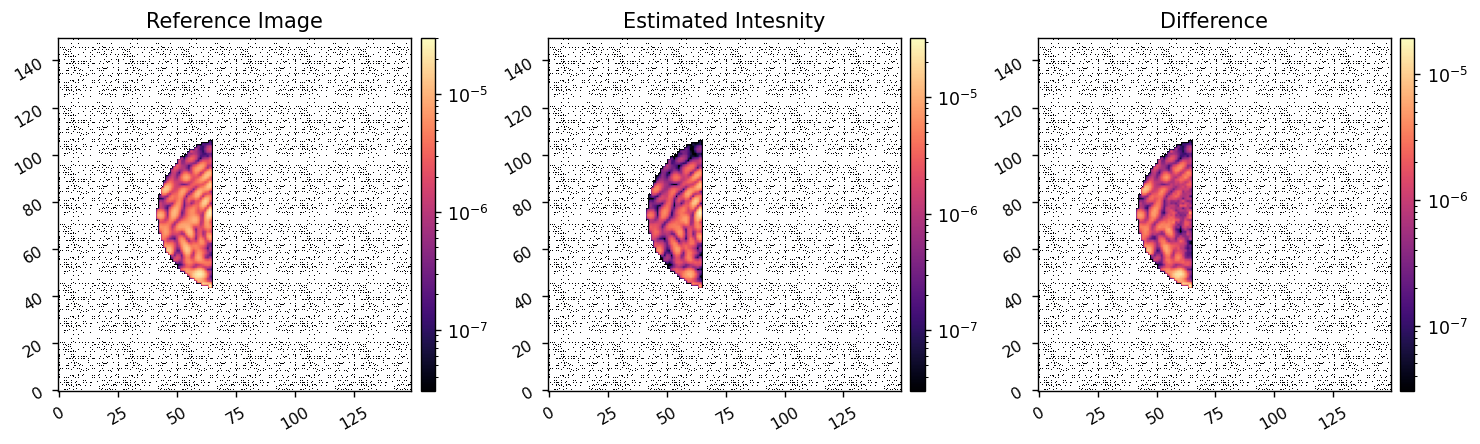

In [72]:
I_diff = ref_coro_im*control_mask - 2*I_pwp
vmin = xp.max(ref_coro_im*control_mask)/1e3
imshow3(ref_coro_im*control_mask, 2*I_pwp, xp.abs(I_diff), 
        'Reference Image', 'Estimated Intesnity', 'Difference',
        lognorm1=True, lognorm2=True, vmin1=vmin, vmin2=vmin, 
        lognorm3=True, vmin3=vmin,
        )

In [73]:
I.zero_dm()
data = {
    # 'ref_im':ref_coro_im, 
    'images':[ref_coro_im],
    'efields':[],
    'commands':[],
    'del_commands':[],
    'reg_conds':[],
    'bfgs_tols':[],
    'pixelscale':I.psf_pixelscale_lamDc,
    'control_mask':control_mask, 
}

Running PWP ...


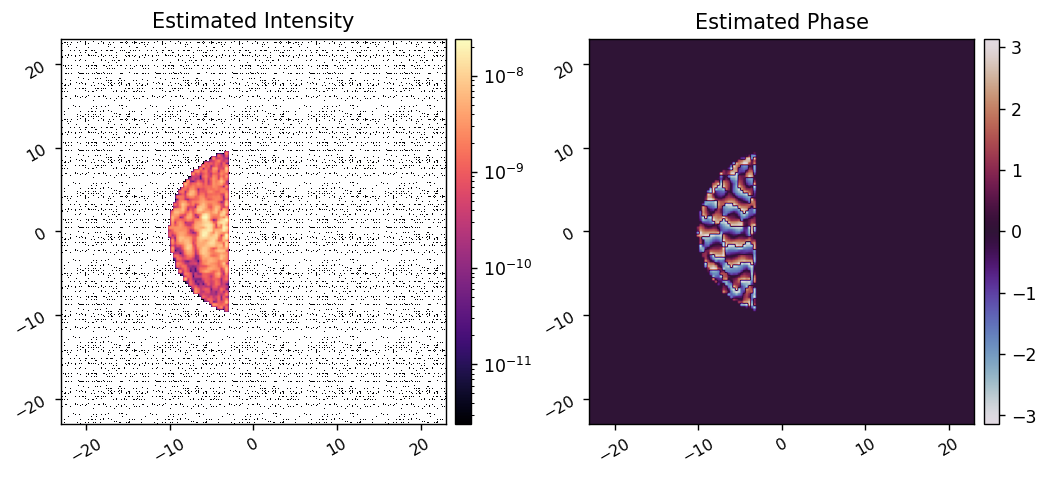

Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          951     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  1.72429D+08


 This problem is unconstrained.



At iterate    1    f=  8.87782D-01    |proj g|=  9.27030D+07

At iterate    2    f=  8.61331D-01    |proj g|=  7.09050D+07

At iterate    3    f=  8.49057D-01    |proj g|=  5.51280D+07

At iterate    4    f=  8.33744D-01    |proj g|=  2.63137D+07

At iterate    5    f=  8.27013D-01    |proj g|=  3.77485D+07

At iterate    6    f=  8.17701D-01    |proj g|=  2.80589D+07

At iterate    7    f=  8.12164D-01    |proj g|=  2.37776D+07

At iterate    8    f=  8.05712D-01    |proj g|=  2.34442D+07

At iterate    9    f=  7.91766D-01    |proj g|=  2.84493D+07

At iterate   10    f=  7.82519D-01    |proj g|=  4.79034D+07

At iterate   11    f=  7.67922D-01    |proj g|=  2.68424D+07

At iterate   12    f=  7.54123D-01    |proj g|=  2.28882D+07

At iterate   13    f=  7.41293D-01    |proj g|=  3.84707D+07

At iterate   14    f=  7.28436D-01    |proj g|=  3.58810D+07

At iterate   15    f=  7.13617D-01    |proj g|=  2.72391D+07

At iterate   16    f=  6.94199D-01    |proj g|=  3.17938D+07

At iter

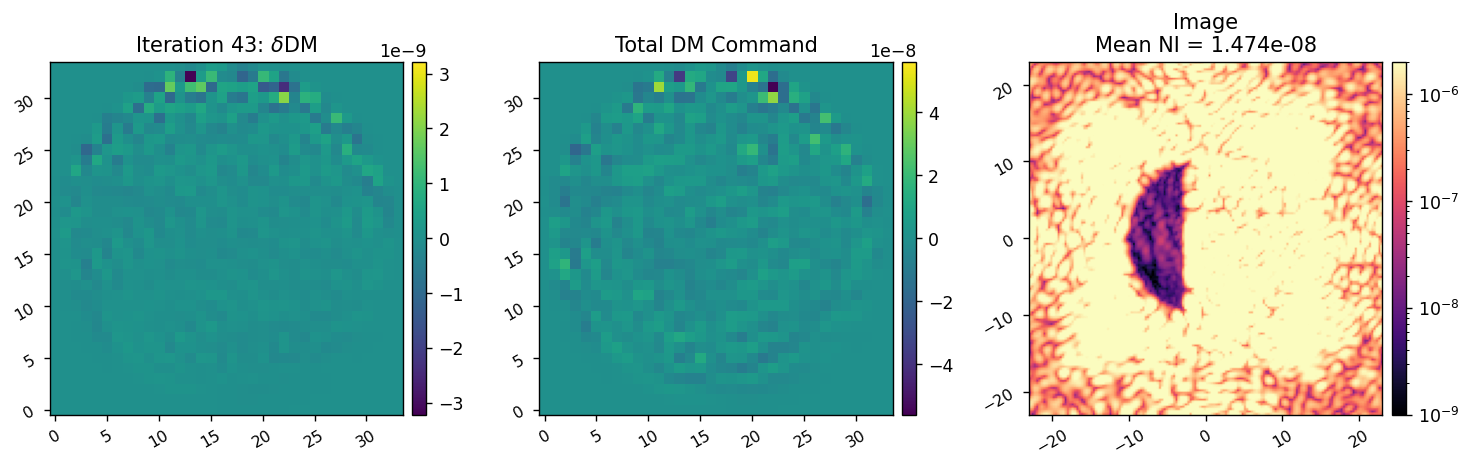

Running PWP ...


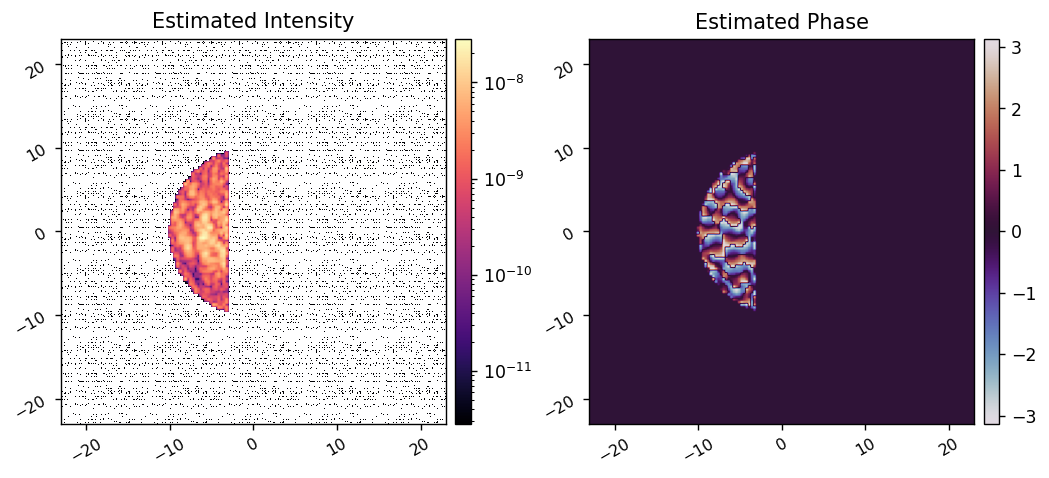

Computing EFC command with L-BFGS
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          951     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  2.64854D+08


 This problem is unconstrained.



At iterate    1    f=  8.21508D-01    |proj g|=  1.24507D+08

At iterate    2    f=  7.70176D-01    |proj g|=  9.15924D+07

At iterate    3    f=  7.42356D-01    |proj g|=  6.23977D+07

At iterate    4    f=  7.17667D-01    |proj g|=  3.44216D+07

At iterate    5    f=  7.05770D-01    |proj g|=  4.45244D+07

At iterate    6    f=  6.94681D-01    |proj g|=  2.27463D+07

At iterate    7    f=  6.88706D-01    |proj g|=  2.34013D+07

At iterate    8    f=  6.81429D-01    |proj g|=  2.28413D+07

At iterate    9    f=  6.70707D-01    |proj g|=  3.84239D+07

At iterate   10    f=  6.61066D-01    |proj g|=  2.29773D+07

At iterate   11    f=  6.54300D-01    |proj g|=  1.79943D+07

At iterate   12    f=  6.45117D-01    |proj g|=  2.21259D+07

At iterate   13    f=  6.38084D-01    |proj g|=  3.03097D+07

At iterate   14    f=  6.27354D-01    |proj g|=  2.41950D+07

At iterate   15    f=  6.20493D-01    |proj g|=  7.45244D+07

At iterate   16    f=  6.03396D-01    |proj g|=  2.10704D+07

At iter

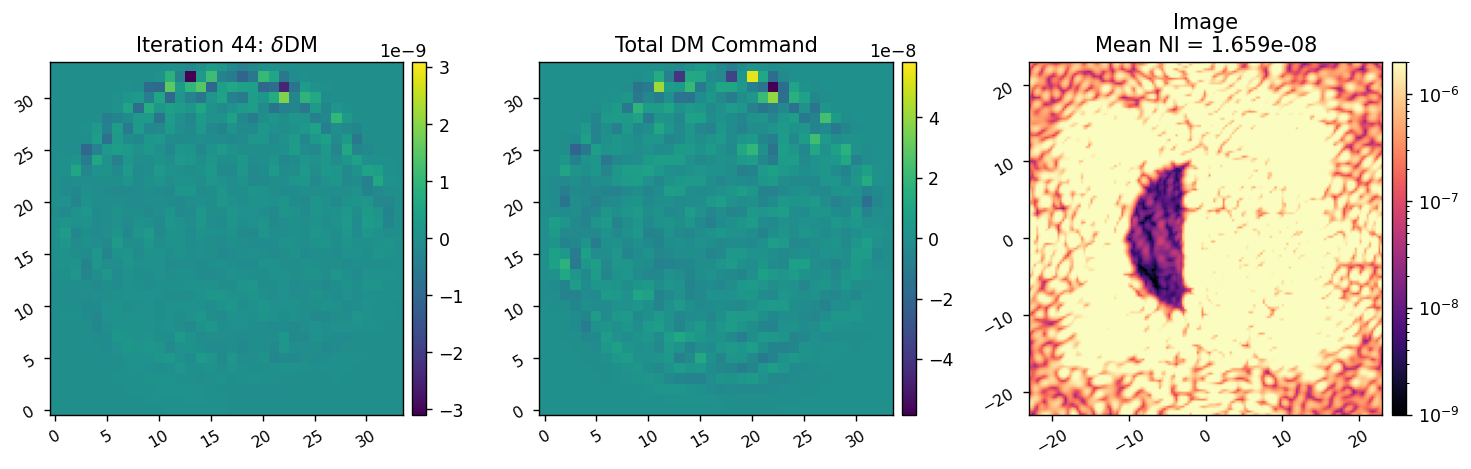

Running PWP ...


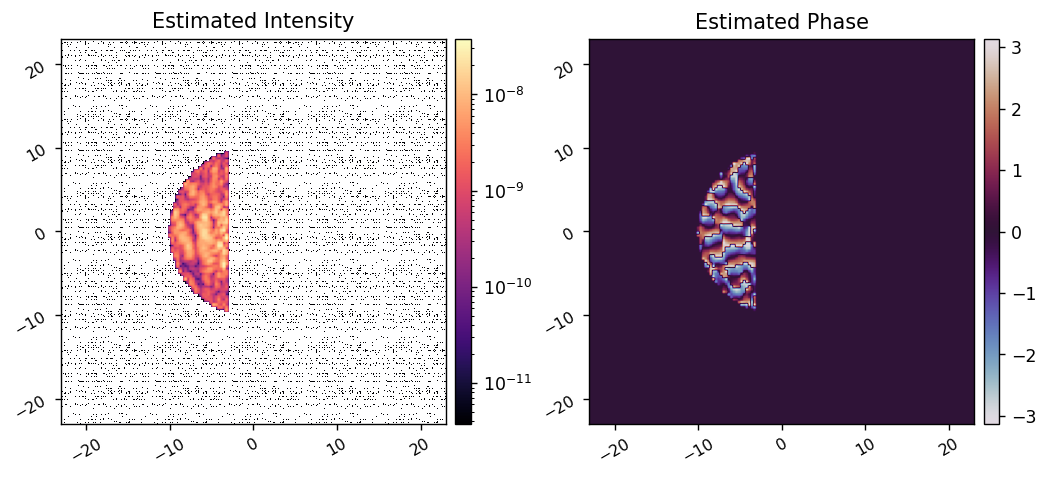

Computing EFC command with L-BFGS


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          951     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  3.07052D+08

At iterate    1    f=  7.68790D-01    |proj g|=  1.18945D+08

At iterate    2    f=  6.99753D-01    |proj g|=  9.12206D+07

At iterate    3    f=  6.71550D-01    |proj g|=  7.26671D+07

At iterate    4    f=  6.39683D-01    |proj g|=  3.73804D+07

At iterate    5    f=  6.29129D-01    |proj g|=  7.03819D+07

At iterate    6    f=  6.12055D-01    |proj g|=  1.99797D+07

At iterate    7    f=  6.05900D-01    |proj g|=  1.93770D+07


In [ ]:
reload(scoobm)
reload(efc)

I.NSCICAM = 20

pwp_params = {
    'M':M,
    'control_mask':control_mask, 
    'probes':fourier_probes,
    'probe_amp':2.5e-9,
    'probe_amp':1e-9,
    'probe_amp':0.5e-9,
    'wavelength':I.wavelength_c,
    'reg_cond':1e-2,
    # 'reg_cond':1e-3,
    # 'reg_cond':1e-4,
    'Ndms':1,
    # 'plot':True,
    'plot_est':True, 
}

data = efc.run(
    I, 
    cm15, 
    # cm20,
    # cm25,
    # cm30,
    # cm35,
    # cm40,
    # cm45,
    # cm50,
    control_mask, 
    data,
    pwp_params=pwp_params,
    Nitr=3,
    gain=1,
)

In [120]:
utils.save_pickle(f'data/{today}_scoob_aefc_run.pkl', data)

Saved data to:  data/20241217_scoob_aefc_run.pkl


# Adjust attenuation for better SNR.

In [83]:
I.set_fib_atten(0, client)

Set the fiber attenuation to 0.0


3.33520386342086e-08


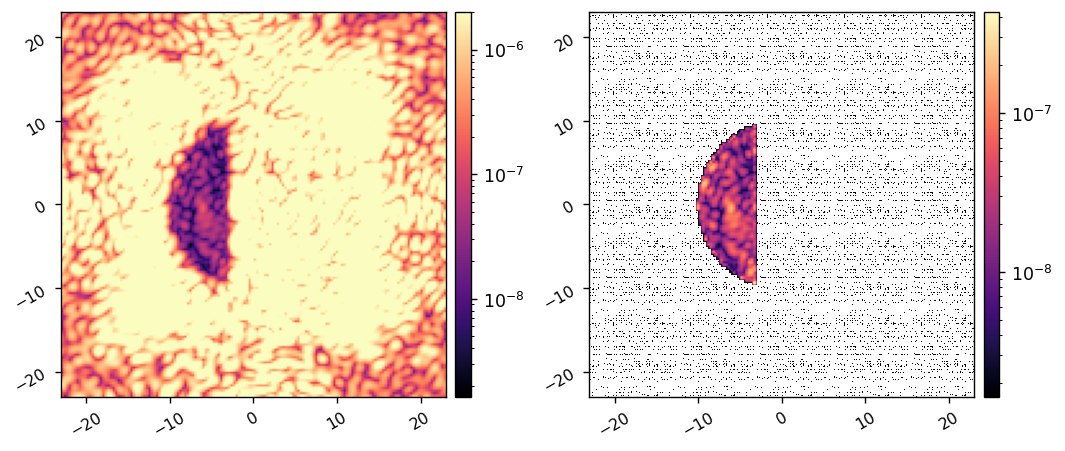

In [84]:
I.NSCICAM = 10
I.subtract_dark = True
I.return_ni = True

coro_im = I.snap()

print(xp.mean(coro_im[control_mask]))
imshow2(coro_im, control_mask * coro_im,
        lognorm=True, pxscl=I.psf_pixelscale_lamDc)

In [119]:
I.zero_dm()
I.set_zwo_exp_time(0.0001, client0)
I.set_fib_atten(0, client)

Set the ZWO exposure time to 1.00e-04s
Set the fiber attenuation to 0.0


In [127]:
I.set_zwo_exp_time(0.001, client0)

Set the ZWO exposure time to 1.00e-03s


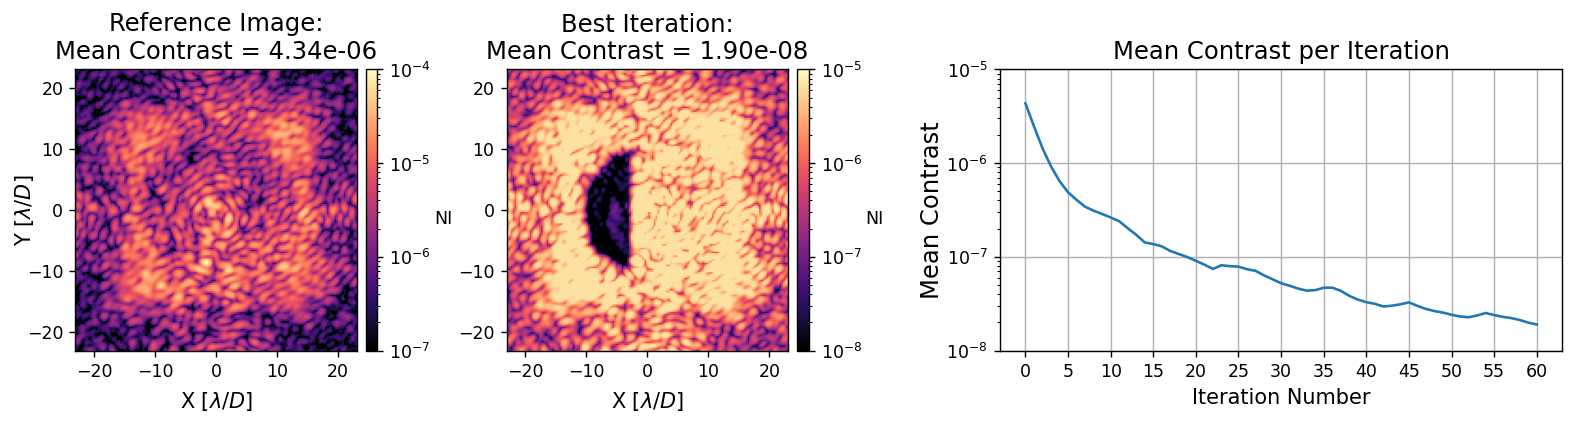

In [128]:
from adefc_vortex import imshows
reload(imshows)

imshows.plot_data_with_ref(
    data, 
    im1vmax=1e-4, im1vmin=1e-7, 
    im2vmax=1e-5, im2vmin=1e-8, 
    vmax=1e-5, vmin=1e-8, 
    xticks=np.arange(0, 61, 5),
    fname='../figs/scoob_mono_result.pdf'
)

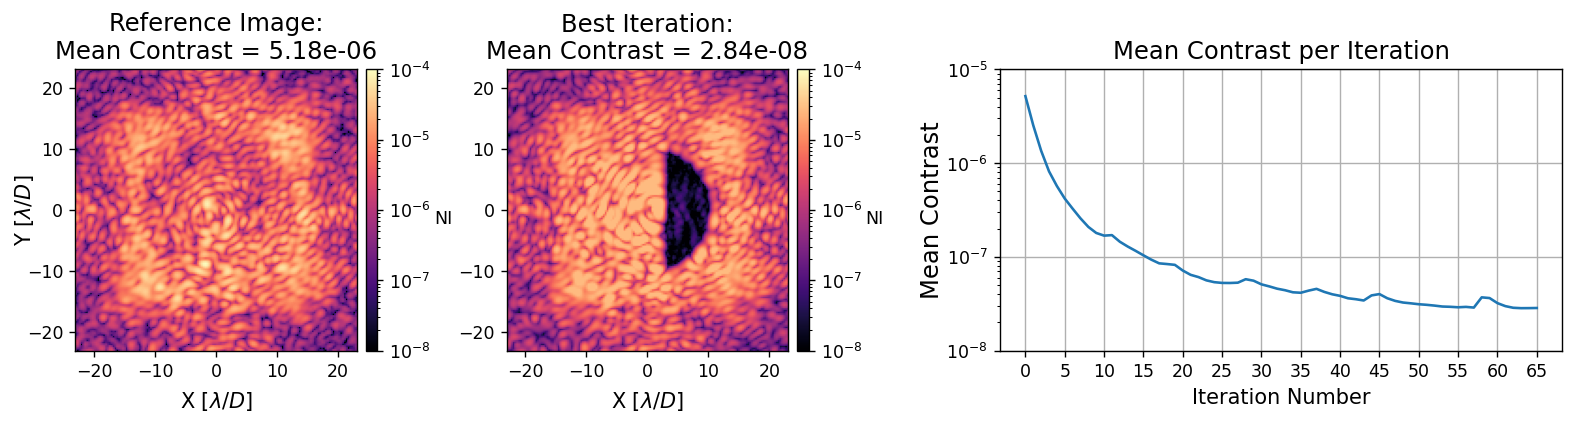

In [184]:
from adefc_vortex import imshows
reload(imshows)

imshows.plot_data_with_ref(
    data, 
    im1vmax=1e-4, im1vmin=1e-8, 
    im2vmax=1e-4, im2vmin=1e-8, 
    vmax=1e-5, vmin=1e-8, 
    xticks=np.arange(0, 66, 5),
)

In [10]:
M = scoobm.MODEL()
iwa = 3
owa = 10
rotation = 0
control_mask = utils.create_annular_focal_plane_mask(M.npsf, M.psf_pixelscale_lamDc, iwa, owa, edge=iwa, rotation=rotation)


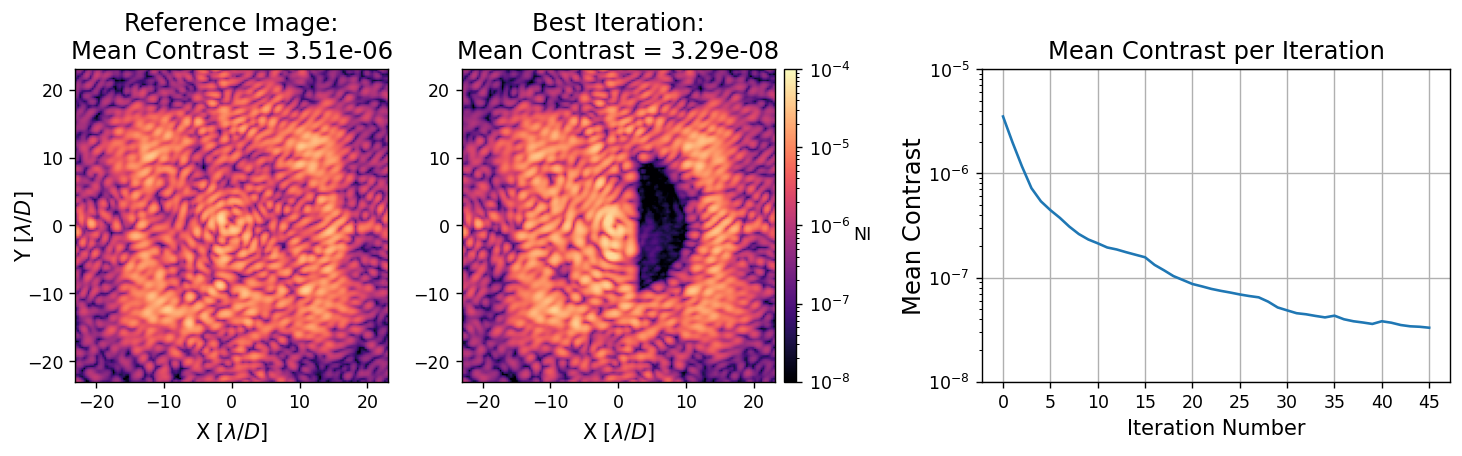

In [25]:
from adefc_vortex import imshows
reload(imshows)

date = 20241029
ref_im = utils.load_fits(f'data/{date}_ref_coro_im.fits')
ims = utils.load_fits(f'data/{date}_adefc_ims.fits')

data = {
    'images':xp.concatenate([xp.array([ref_im]), ims]),
    'control_mask': control_mask,
    'pixelscale':M.psf_pixelscale_lamDc,
}

imshows.plot_data(
    data, 
    imvmax=1e-4, imvmin=1e-8, 
    vmax=1e-5, vmin=1e-8, 
    xticks=np.arange(0, 46, 5),
)
